# Neural coding

## References:

### Convolutional Neural Networks (CNN)

### Convolutional autoencoder
A neural network with unsupervised training, which means that we don't need to supply a target function. There is only a training set, which is also the target set. A convolutional autoencoder uses convolutional neural networks. An autoencoder maps the input signal to a lower dimensional representation using its encoder part. In this way it is similar for instance to an audio encoder, which compresses an audio signal into a representation with fewer bits than the original audio signal. The decoder part of an autoencoder maps the lower dimensional representation back into the higher dimensional representation. This is similar to an audio decoder, which decodes the compressed version back to an audio signal. The reconstruction after the decoder part should be as close as possible to the original. Hence the original (the training set) is also the target.

### Pytorch
PyTorch is an open-source machine learning framework that provides a flexible and efficient platform for building and training deep learning models. It has become one of the most popular deep learning frameworks due to its flexibility, Pythonic interface, and extensive support for GPUs (Graphics Processing Units), which are crucial for accelerating deep learning computations.

### Tensor
A tensor is a mathematical object that generalizes scalars, vectors, and matrices to higher dimensions. In deep learning and machine learning, a tensor is a data structure that is used to store multi-dimensional data, and it's the basic building block for computations in frameworks like PyTorch and TensorFlow.

### Activation function
An activation function used in the encoder part of a model, like tanh, helps introduce non-linearity and restricts the encoded output to a range between -1 and 1. The decoder does not use an activation function, which allows the model to reconstruct the input more directly.

### Bias
In a neural network layer, bias is a learnable parameter added to the output of the convolution (or any other operation, like a fully connected layer). It allows the model to shift the activation function output by some constant amount, helping the model fit the data better.

### Loss function
A loss function is a mathematical function that measures the difference between the predicted output of a machine learning model and the actual target values (ground truth). It quantifies how "wrong" the model's predictions are, guiding the optimization process to adjust the model's parameters to minimize the error. Mean Squared Error (MSE) is a common loss function.

### Model weights
The parameters within a neural network that the model learns during training. These weights are the values that the model adjusts to better predict the target output from the input data. In deep learning, weights are crucial because they define the strength of connections between neurons in different layers of the network.

### Optimizer
Algorithm used to adjust the parameters (such as weights and biases) of a model in order to minimize the loss function during training. The optimizer updates the model parameters based on the gradients computed through backpropagation, with the goal of finding the optimal set of parameters that minimize the error between predicted and actual values.

### Model predictions




In [3]:
# for using colab need to uncomment this
# !git clone https://github.com/xserra/audio-coding-materials.git

In [4]:
import torch
import torch.nn as nn
# import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read

device = 'cpu'

In [5]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def signal2pytorch(x):
    #Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

## Part 1 - Convolution autoencoder

In [6]:
# define model graph

class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        xrek=self.decoder(y)
        return xrek

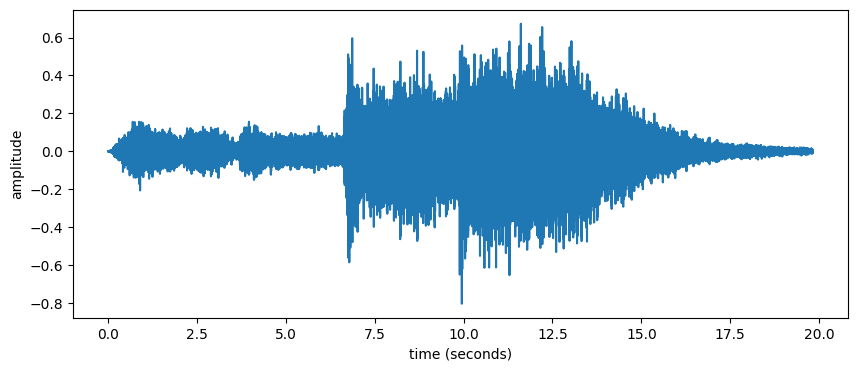

In [7]:
# read training data
batch=1
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")
X_train = signal2pytorch(audio1).to(device)
display_sound(audio1, samplerate)

In [8]:
# Generate Model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()

Ypred=model(X_train)

#length of the signal at the output of the network.
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)

#the target signal with same length as model output
Y=X_train[:,:,:outputlen]

print("Input X.shape =", X_train.shape)
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Total number of parameters: 131105
outputlen= 873474
Input X.shape = torch.Size([1, 1, 874006])
Target Y.shape = torch.Size([1, 1, 873474])
Target Y = tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0068, -0.0069, -0.0069]]])
Y.type() = torch.FloatTensor


In [9]:
# train model
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred = model(X_train)
print("Ypred=", Ypred)

# train the model over a number of epochs
nepocs = 100
for epoch in range(nepocs):
  Ypred=model(X_train)
  loss=loss_fn(Ypred, Y)
  if epoch%10==0:
    print(epoch, loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Ypred= tensor([[[0.0144, 0.0152, 0.0157,  ..., 0.0172, 0.0133, 0.0167]]],
       grad_fn=<ConvolutionBackward0>)
0 0.010090530849993229
10 0.009741698391735554
20 0.009138151071965694
30 0.008246384561061859
40 0.007270142901688814
50 0.006418467033654451
60 0.005745751783251762
70 0.005224713124334812
80 0.004833157639950514
90 0.004553096368908882


ww= OrderedDict({'conv1.weight': tensor([[[ 6.8211e-03,  2.6653e-04, -8.6631e-03,  ...,  1.7509e-02,
          -7.6876e-03,  2.3260e-02]],

        [[ 4.6299e-03, -5.2963e-04,  2.1460e-02,  ...,  2.5285e-02,
           2.3092e-02,  1.6575e-02]],

        [[ 2.7694e-02,  2.4283e-02,  2.4307e-02,  ...,  3.6525e-03,
           1.1508e-02,  1.2221e-03]],

        ...,

        [[ 9.2730e-03, -1.6435e-02, -9.4652e-03,  ...,  2.9077e-02,
           2.9436e-03,  1.3496e-02]],

        [[-1.8748e-02, -2.4553e-03, -1.4008e-02,  ..., -1.4110e-02,
           1.2496e-02, -1.1462e-02]],

        [[ 1.0707e-02,  9.5613e-05,  2.1187e-02,  ...,  3.6596e-03,
          -5.8822e-03,  9.8086e-03]]]), 'conv1.bias': tensor([ 0.0212, -0.0261, -0.0233, -0.0090,  0.0148, -0.0060, -0.0152, -0.0050,
         0.0247,  0.0085, -0.0201,  0.0122, -0.0162,  0.0003, -0.0099, -0.0092,
        -0.0112, -0.0185, -0.0279,  0.0251,  0.0257,  0.0071, -0.0145,  0.0150,
         0.0067,  0.0178,  0.0098,  0.0063, -0.0132,  0.

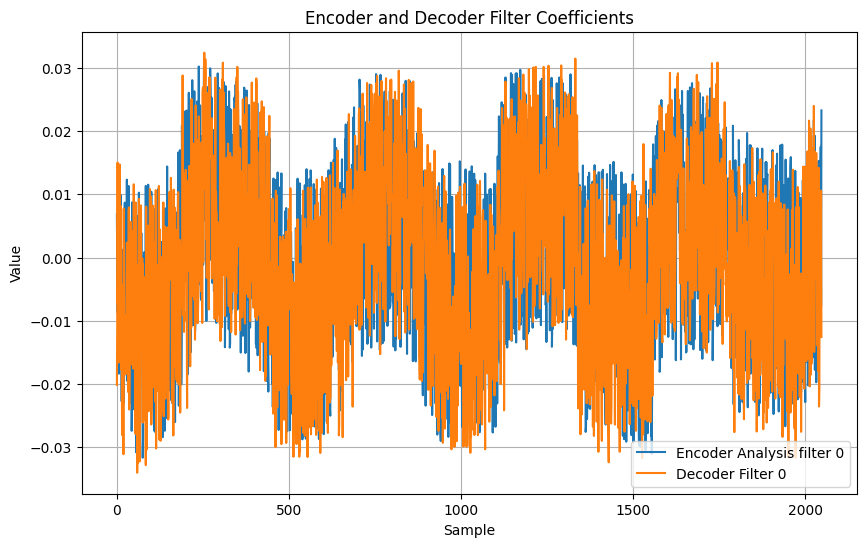

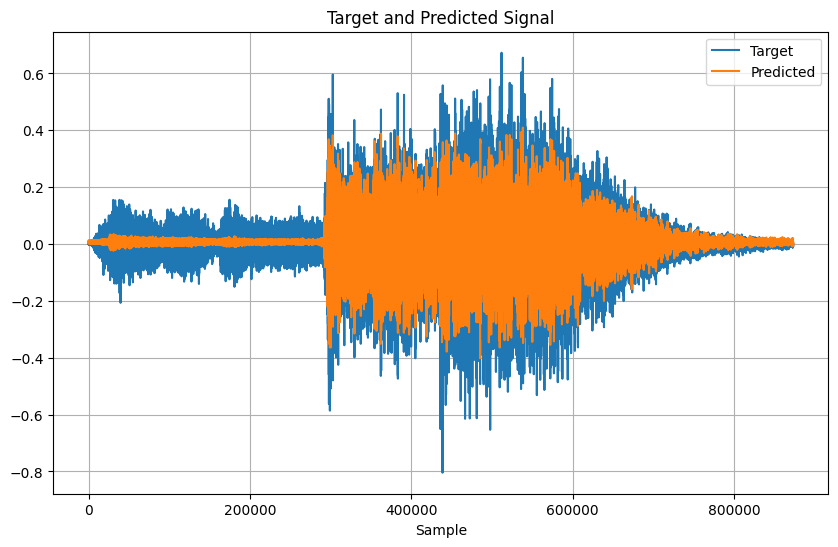

In [10]:
# make predictions using the training set

#read obtained weights
ww = model.state_dict()
print("ww=", ww)

#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.grid()

# Make Predictions based on the obtained weights, on training set
predictions = model(X_train).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
Y=np.array(Y) #target
print("predictions.shape=", predictions.shape)
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Target','Predicted'))
plt.title('Target and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
#remove unnecessary dimension for playback
xrek=predictions[:,0,:]

In [11]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

**Questions:**

1. Find a good prediction using the least number of epochs

## Part 2 - Generalization of model

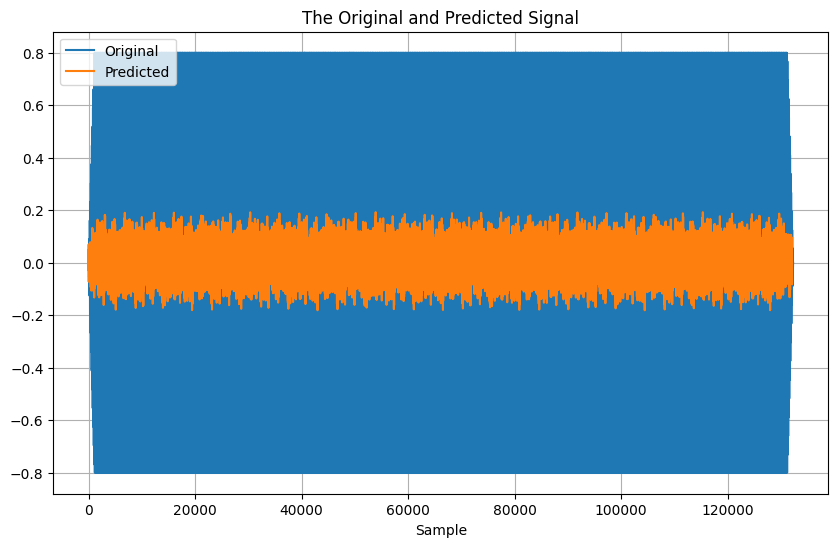

In [12]:
#Test on data different from the training one

# audio2, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("../sounds/sinewave.wav")
X_test=signal2pytorch(audio2).to(device) #Convert to pytorch format, batch is first dimension

# Make Predictions based on the obtained weights, on verification set
predictions = model(X_test).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
plt.figure(figsize=(10,6))
plt.plot(np.array(X_test[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]

In [13]:
#play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

**Questions:**

1. Explore the generation capability of model.